<a href="https://colab.research.google.com/github/Tecnologico-de-Monterrey-MNA/nlp-2023-Equipo-12/blob/main/Equipo12_semana05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

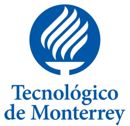

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Estrategia de implementación de servicios tecnológicos**
### Tecnológico de Monterrey
### Prof Luis Eduardo Falcón Morales

## **5.2 Actividad**
## Actividad en Equipos - Semana 5:

### **Modelos Embebidos: Caso Amazon/Yelp/IMDb**
____________

## Equipo 12
> - Francisco Javier Parga Garcia  **A01794380**
>
> - Enrique Hernández García **A01793727**
>
> - Matthias Sibrian Illescas **A01794249**
>
> - Alejandro Tomás Mackey **A01164338**
>
> - Ignacio Valdés Reyes **A0179326**




# 0. Librerias

## Instalacion de complementos no presentes en Google-Colab

In [75]:
!pip install fasttext 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
# Librerias reaueridas para el ejercico

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import string
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

import fasttext
import fasttext.util

In [77]:
# Herramientas para nltk

nltk.download('punkt')   
nltk.download('stopwords') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# 1. Carga de datos


1. Descarga los 3 archivos de Canvas. En particular, el archivo de datos de IMDb ya no requiere
transformarse para obtener sus 1000 registros. Al cargar los datos de los tres archivos deberás
tener un DataFrame de Pandas de 3000 registros, con sus etiquetas. Los archivos los encuentras en
Canvas y se llaman: amazon5.txt, imdb5.txt, yelp5.txt.

In [78]:
dfa = pd.read_csv('amazon5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')
dfi = pd.read_csv('imdb5.txt', sep='   ', names=['review','label'], header=None, encoding='utf-8', engine='python')
dfy = pd.read_csv('yelp5.txt', sep='\t', names=['review','label'], header=None, encoding='utf-8')


print('Total de registros de Amazon:',dfa.shape)
print('Total de registros de IMBD:',dfi.shape)
print('Total de registros de Yelp:',dfy.shape)

Total de registros de Amazon: (1000, 2)
Total de registros de IMBD: (1000, 2)
Total de registros de Yelp: (1000, 2)


## Union de datos


In [79]:
df = pd.concat([dfa, dfi, dfy], ignore_index=True)
df = df.dropna()

print(f'Total de reviews: {df.shape[0]}')
df.head()

Total de reviews: 3000


,review,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


# 2. Limpieza de datos

2. Realiza de nuevo un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado, sin
embargo, deberás aplicar necesariamente alguna de las técnicas de lematización. Como aplicaremos
modelos embebidos pre-entrenados, queremos palabras lo más cercanas a las existentes en un
idioma, inglés en este caso. Aplica y justifica cualquier otro proceso de limpieza que consideres
adecuado. Recuerda que en esta actividad se usarán vectores embebidos para un problema de
clasificación, por lo que deberás tomar de acuerdo a este contexto. Justifica todas las
transformaciones que se apliquen.

## Funciones para limpieza

In [80]:
def clean_tok(doc):
  """
  Funcion para crear limpiar texto y crear tokens:
    -Regulariza en minusculas todo el texto
    -Elimina puntos antes de tokenizar
    -Tokeniza el texto
    -Elimina puntuación adicional
    -Elimina stopwords
    -Convertie a lemas basado en el tipo de de etiqueta en wornet
    -Elimina tokens de 1 caracter

  Inputs:
    doc: string

  Outputs
    tokens: list

  """
  import string
  from nltk.tokenize import word_tokenize

  negwords = [ 'no', 'nor', 'not', 'ain', 'aren', "aren't", 'don', "don't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
  mystopwords = set(stopwords.words('english')) - set(negwords)
  
  # Convierte puntos a espacios antes de tokenizar
  doc = doc.replace(".", " ")
  doc = doc.replace("-", " ")
  
  if doc == '10/10':
    doc = 'ten of ten'

  # Convertir a minúsculas y eliminar puntuacion
  doc = doc.translate(str.maketrans("", "", string.punctuation)).lower()

  #Eliminar numeros y tokenizar
  doc_tokens = ''.join(char for char in doc if not char.isdigit()).split()

  #Eliminar stopwords y tokens de 1 solo caracter
  tokens_list = [token for token in doc_tokens if token not in mystopwords and len(token) > 1]

  # Lematización
  tokens = lemmas_doc(tokens_list)
  
  # Considerar solo tokens de longitud mayor a 1
  #tokens = [token for token in tokens if len(token) > 1]

  return tokens

In [81]:
import string
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#Diccionario para mapear tipo de etiqueta con wordnet
tag_map = {
          'J': wordnet.ADJ,
          'V': wordnet.VERB,
          'N': wordnet.NOUN,
          'R': wordnet.ADV
          }

#Funcion para obtener la etiqueta de la palabra
def get_wordnet_pos(token):
    token_char = token[0]
    return tag_map.get(token_char, None)

def lemmas_doc(doc):
       
    lemmatizer = WordNetLemmatizer()
    
    tagged_tokens = nltk.pos_tag(doc)
    
    #Lematizar tokens en base al timpo de palabra
    lemmas = []
    for word, tag in tagged_tokens:
        word_tag = get_wordnet_pos(tag)
        if word_tag is None:
            lemma = lemmatizer.lemmatize(word) 
        else:
            lemma = lemmatizer.lemmatize(word, pos=word_tag) 
        lemmas.append(lemma)

    return lemmas

## Limpieza del dato

In [82]:
X = df.review.values
y = df.label.values

Xclean = [clean_tok(x) for x in X]
Xclean[0:5]

[['no', 'way', 'plug', 'u', 'unless', 'go', 'converter'],
 ['good', 'case', 'excellent', 'value'],
 ['great', 'jawbone'],
 ['tie', 'charger', 'conversation', 'last', 'minute', 'major', 'problem'],
 ['mic', 'great']]

________
> Nos decidimos a usar solo palabras en minuscula, solo texto, sin stopwords y lematizado porque creemos que son las palabras que vamos a encontrar en su estado general en el modelo pre
entrenado, eliminamos numeros y signos de puntuacion porque no aportan mucha informacion al mensaje. Adicionalmente vamos a obtener vectores de cercania por palabra, requerimos que
esten cercanas a su estado basico.
________

La longitud media de las oraciones limpias es: 6.291333333333333
La mediana es: 5.0
Con una deviacion estandar de: 4.2187428880598485
Oracion mas corta de: 1


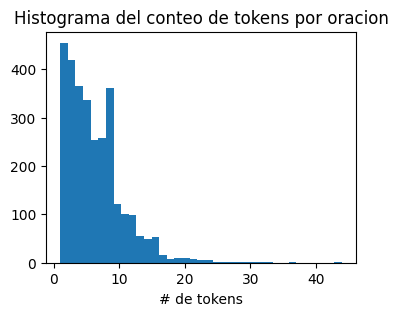

In [83]:
print(f'La longitud media de las oraciones limpias es: {np.mean([len(x) for x in Xclean])}')
print(f'La mediana es: {np.median([len(x) for x in Xclean])}')
print(f'Con una deviacion estandar de: {np.std([len(x) for x in Xclean])}')
print(f'Oracion mas corta de: {np.min([len(x) for x in Xclean])}')

plt.figure(figsize=(4,3))
plt.hist([len(x) for x in Xclean], bins=37)
plt.title('Histograma del conteo de tokens por oracion')
plt.xlabel('# de tokens')
plt.show()

# 3. Separacion del dato

3. Llamar Xclean a los comentarios procesados y Y a las etiquetas. Realicemos una partición aleatoria
con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de
esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba,
respectivamente. Verifica que obtienes 2100 registros de entrenamiento y 450 para cada uno de
validación y prueba.

In [84]:
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, y, train_size=.70, shuffle=True, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)
print('X,y Train:', len(X_train), len(y_train))  
print('X,y Val:', len(X_val), len(y_val))
print('X,y Test', len(X_test), len(y_test))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


# 4. Definicion de vocabulario

4. Usando el conjunto de entrenamiento genera un vocabulario que no sea mayor a 1500 palabras, ni
menor a 1000. ¿Por qué es importante acotar un vocabulario inferior y superiormente? ¿Por qué
debe usarse solamente el conjunto de entrenamiento para generar el diccionario? Con este vocabulario que obtienes, filtra los conjuntos de entrenamiento, validación y prueba, de esta
manera todos los comentarios usarán solamente palabras válidas de acuerdo a este vocabulario.
Indica el tamaño del vocabulario obtenido.
Hasta este punto básicamente has realizado transformaciones muy análogas a las de la semana
pasada y que son válidas para muchos de los procesos dentro del análisis de textos. En dado caso
comenta con tus compañeros de equipo qué diferencias has observado. Veamos ahora la diferencia
con respecto a las matrices Tf-idf que aplicaste la semana pasada, con respecto a los vectores preentrenados
embebidos.

In [85]:
midiccionario = Counter()    

for k in range(len(X_train)):
    midiccionario.update(X_train[k])


print('Longitud del diccionario:', len(midiccionario))  
print('\n(word,frequency):') 
print(midiccionario.most_common(10)) 

Longitud del diccionario: 3461

(word,frequency):
[('not', 218), ('good', 178), ('great', 141), ('movie', 140), ('phone', 133), ('film', 130), ('work', 112), ('time', 101), ('bad', 101), ('one', 99)]


In [86]:
min_freq = 2

vocabulario = {x: count for x, count in midiccionario.items() if count >= min_freq}

print('Nueva longitud del nuevo vocabulario:', len(vocabulario))
print(list(vocabulario.items())[0:5]) 

Nueva longitud del nuevo vocabulario: 1465
[('star', 18), ('dont', 59), ('fare', 2), ('much', 39), ('good', 178)]


____
> Filtramos 1465 palabras de acuerdo a la frecuencia minima de 2 veces presentes en el corpus
____

## Filtrado de datasets con el nuevo vocabulario

In [87]:
x_train = []
for token_sentence in X_train:
    x_train.append([w for w in token_sentence if w in vocabulario])

x_val = []
for token_sentence in X_val:
    x_val.append([w for w in token_sentence if w in vocabulario])

x_test = []
for token_sentence in X_test:
    x_test.append([w for w in token_sentence if w in vocabulario])

____
**_¿Por qué es importante acotar un vocabulario inferior y superiormente?_** 

>Porque si no acotamos un límite inferior, podemos incluir palabras que aparecen muy poco en todo el corpus; es decir, que no son relevantes. Respecto al límite superior, porque mientras más palabras entren en el vocabulario necesitamos mas registros para entrenar el modelo, el modelo se vuelve mas complejo en cantidad de características

**_¿Por qué 
debe usarse solamente el conjunto de entrenamiento para generar el diccionario?_**

>Porque estas son las palabras que van a ajustar el modelo que despues vamos a probar. Si nos encontramos con muchas palabras con las que no entrenamos despues, vamos a tener
un mal desempeño en el modelo. Tampoco debemos de usar los datos de validaciónn y prueba para generar un diccionario, ya que el modelo tendría overfitting y no funcionaría de manera adecuada frente a datos completamente nuevos.
____

___
**_En dado caso comenta con tus compañeros de equipo qué diferencias has observado._**

>En el caso de la semana pasada no habia renglones vacíos, al momento de filtrar palabras perdimos información.
Pero en este caso no solo estamos contando la frecuencia de las palabras para tomar decisiones. fastText va a añadir caracteristicas por palabra que le dan mas profundidad.
En este caso es mas sensato tomar un numero reducido de palabras para no sobrecargar el proceso del modelo.
___

### Eliminacion de muestras vacias

Despues de filtrar los datos con el vocabulario, quedaron datos sin oraciones, es necesario filtrarlos

In [88]:
print(f'Indices en datos de entrenamiento vacios: {[i for i,x in enumerate(x_train) if len(x)<1]}')
print(f'Indices en datos de validacion vacios: {[i for i,x in enumerate(x_val) if len(x)<1]}')
print(f'Indices en datos de prueba vacios: {[i for i,x in enumerate(x_test) if len(x)<1]}')

Indices en datos de entrenamiento vacios: [86, 147, 331, 731, 776, 1340, 1456, 1672]
Indices en datos de validacion vacios: [147, 212, 275, 331, 362, 446]
Indices en datos de prueba vacios: [103, 201, 258, 264, 275, 315, 342, 423]


In [89]:
def remove_empty_lists(x_train, y_train):
    # Zip x_train and y_train together for simultaneous iteration
    zipped_data = zip(x_train, y_train)

    # Filter out empty lists and corresponding records
    filtered_data = [(x, y) for x, y in zipped_data if x]

    # Unzip the filtered data into separate lists
    x_train_filtered, y_train_filtered = zip(*filtered_data)

    return list(x_train_filtered), list(y_train_filtered)

In [90]:
x_train_filtered, y_train_filtered = remove_empty_lists(x_train, y_train)
x_test_filtered, y_test_filtered = remove_empty_lists(x_test, y_test)
x_val_filtered, y_val_filtered = remove_empty_lists(x_val, y_val)

# 5. Vectores embebidos

5. Utilizarás los vectores embebidos FastText preentrenados por Facebook.
a. Incluye una tabla comparativa de pros y contras entre los modelos FastText, word2vec de
Google y Glove de Stanford. Puedes consultar sus páginas correspondientes:

>- https://fasttext.cc/

>- https://code.google.com/archive/p/word2vec/

>- https://nlp.stanford.edu/projects/glove/

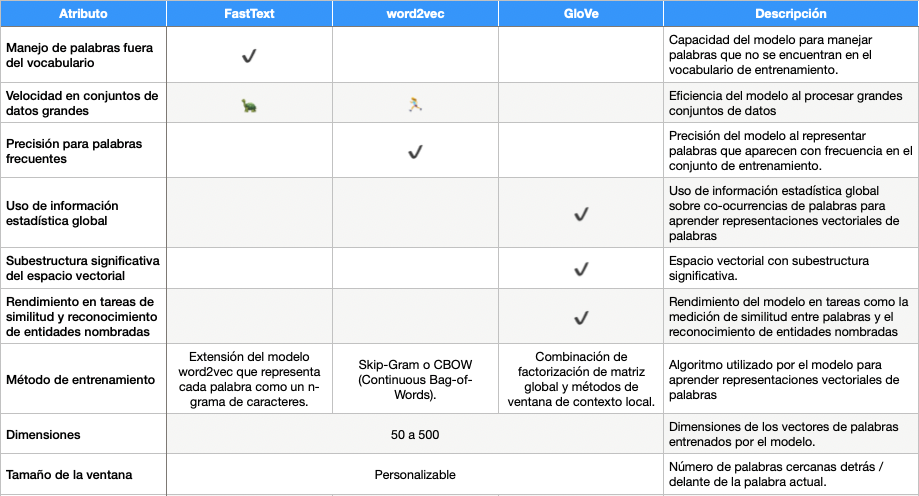

Fuentes:

*   Cr, A. (2021, 15 diciembre). Word Embeddings in NLP | Word2Vec | GloVe | fastText. Medium. https://medium.com/analytics-vidhya/word-embeddings-in-nlp-word2vec-glove-fasttext-24d4d4286a73
*   Deep, A. (2021, 15 diciembre). Word2Vec, GLOVE, FastText and Baseline Word Embeddings step by step. Medium. https://medium.com/analytics-vidhya/word2vec-glove-fasttext-and-baseline-word-embeddings-step-by-step-d0489c15d10b
*   Introduction to word embeddings – Word2Vec, Glove, FastText and ELMo – Data Science, Machine Learning, Deep Learning. (s. f.). https://www.alpha-quantum.com/blog/word-embeddings/introduction-to-word-embeddings-word2vec-glove-fasttext-and-elmo/
*   Sitender, N., Sangeeta, N., Sushma, N. S., & Sharma, S. K. (2023). Effect of GloVe, Word2Vec and FastText Embedding on English and Hindi Neural Machine Translation Systems. En Lecture notes in networks and systems (pp. 433-447). Springer International Publishing. https://doi.org/10.1007/978-981-19-7615-5_37
*   Train static word embeddings using the Word2Vec, GloVe, or FastText algorithm. — train_wordvec. (s. f.). https://psychbruce.github.io/PsychWordVec/reference/train_wordvec.html
*   Van Otten, N. (2023). Word Embedding A Powerful Tool — How To Use Word2Vec GloVe, FastText. Spot Intelligence. https://spotintelligence.com/2022/11/30/word-embedding/
*   What’s the major difference between glove and word2vec? (s. f.). Stack Overflow. https://stackoverflow.com/questions/56071689/whats-the-major-difference-between-glove-and-word2vec
*   Word2Vec, GLOVE, FastText y Baseline Word Embeddings paso a paso. (2020). ICHI.PRO. https://ichi.pro/es/word2vec-glove-fasttext-y-baseline-word-embeddings-paso-a-paso-229010274898187



In [92]:
# Modelo fasttext

fasttext.util.download_model('en', if_exists='ignore') 
ft = fasttext.load_model('cc.en.300.bin')

# 6. Vectores filtrados al vocabulario

6. Utiliza el modelo FastText de vectores embebidos pre-entrenados de dimensión 300 para generar
un nuevo diccionario clave-valor, donde la “clave” será cada token o palabra de tu vocabulario y el
“valor” será su vector embebido de dimensión 300. Este diccionario deberá ser del mismo tamaño
que el vocabulario previo que hayas construido previamente.

In [95]:
diccionario_embebidos = {}

# Obtener el vector embebido para cada palabra
for palabra in vocabulario:
    try:
        vector_embebido = ft.get_word_vector(palabra)
        diccionario_embebidos[palabra] = vector_embebido
    except:
        print(palabra)

## 7. Vectores promedio por comentario

7. Una manera de utilizar los vectores embebidos con modelos de aprendizaje automático en
documentos de texto, es asignar a cada comentario filtrado el vector embebido de dimensión 300
que resulta de promediar todos sus tokens. Así, en este ejercicio deberás generar los arreglos
correspondientes para los conjuntos de entrenamiento, validación y prueba. Los llamaremos
trainEmb, valEmb y testEmb, respectivamente. ¿Cuáles son sus dimensiones? ¿Se podrían usar para
su representación matrices dispersas (sparse matrices) como en el caso de la matriz Tf-idf?
Responde a dichas preguntas.

In [96]:
def calculate_average_vector(vectors):
    if len(vectors) == 0:
        return None

    # Convert the list of vectors into a NumPy array
    vectors_array = np.array(vectors)

    # Calculate the average vector
    average_vector = np.mean(vectors_array, axis=0)

    return average_vector.tolist()


#promediando los componentes de cada vector

def calculate_average_vectors(list_of_lists, word_vectors_dict):
    result_vectors = []
    
    for sublist in list_of_lists:
        sublist_vectors = []
        
        for word in sublist:
            #print(word)
            if word in word_vectors_dict.keys():
                sublist_vectors.append(word_vectors_dict[word])
        
        #print(sublist_vectors)
        average_vector = calculate_average_vector(sublist_vectors)
        result_vectors.append(average_vector)
    
    return np.array(result_vectors)

In [97]:
trainEmb = calculate_average_vectors(x_train_filtered, diccionario_embebidos)
valEmb = calculate_average_vectors(x_val_filtered, diccionario_embebidos)
testEmb = calculate_average_vectors(x_test_filtered, diccionario_embebidos)

In [98]:
print(f'Dimensions for trainEmb: {trainEmb.shape}')
print(f'Dimensions for valEmb: {valEmb.shape}')
print(f'Dimensions for testEmb: {testEmb.shape}')

Dimensions for trainEmb: (2092, 300)
Dimensions for valEmb: (444, 300)
Dimensions for testEmb: (442, 300)


____
**_¿Se podrían usar para 
su representación matrices dispersas (sparse matrices) como en el caso de la matriz Tf-idf?_**

>No, no se trata de una matriz dispersa porque en este caso cada valor extraido tiene un vector poblado de valores diferentes de 0
cada uno representando una caracteristica que no la existencia o no existencia de la palabra como en la tarea anterior, sino multiples marcadores que definen
la palabra en su lugar en el espacio de 300 dimensiones
____

# 8. Modelos de regresion

8. Utiliza los modelos de regresión lineal y bosque aleatorio (random forest) y encuentra sus
desempeños (accuracy). Compara los resultados con los de la semana anterior.

## Regresion logistica para clasificacion binaria

In [ ]:
# Dicccionario para iterar en el calculo de metricas

data_sets = {'train':(trainEmb, y_train_filtered),
             'val':(valEmb, y_val_filtered),
             'test':(testEmb, y_test_filtered)
             }

Accuracy mean: 0.8169268365098035


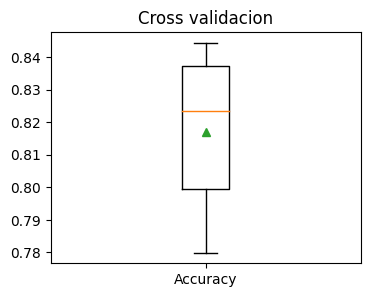

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix

# Create a linear regression model
lr_model = LogisticRegression()

# Fit the model on the training data
lr_cross_val = cross_validate(lr_model, trainEmb, y_train_filtered, cv=5)

mean = lr_cross_val['test_score'].mean()
print(f'Accuracy mean: {mean}')
plt.figure(figsize=(4,3))
plt.boxplot(lr_cross_val['test_score'], labels=['Accuracy'],showmeans=True, vert=True)
plt.xticks(rotation=0)
plt.title('Cross validacion')
plt.show()

In [ ]:
accuracy_lr = {}

lr_model.fit(trainEmb, y_train_filtered)

# Calcular accuracy
for label, data in data_sets.items():
  y_pred_lr = lr_model.predict(data[0])
  accuracy_lr[label] = (accuracy_score(data[1], y_pred_lr), y_pred_lr)
  print(f'Accuracy {label}: {accuracy_lr[label][0]}')

Accuracy train: 0.8398661567877629
Accuracy val: 0.8063063063063063
Accuracy test: 0.8212669683257918


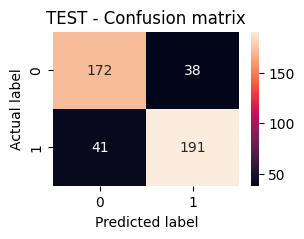

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(data_sets['test'][1], accuracy_lr['test'][1])
 
plt.figure(figsize=(3,2))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('TEST - Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Modelo de bosque aleatoria para clasificacion binaria

Accuracy mean: 0.7906453049525528


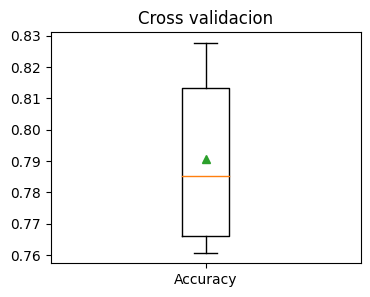

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

# Fit the model on the training data
rf_cross_val = cross_validate(rf_model, trainEmb, y_train_filtered, cv=5)

mean = rf_cross_val['test_score'].mean()
print(f'Accuracy mean: {mean}')
plt.figure(figsize=(4,3))
plt.boxplot(rf_cross_val['test_score'], labels=['Accuracy'],showmeans=True, vert=True)
plt.xticks(rotation=0)
plt.title('Cross validacion')
plt.show()

In [ ]:
accuracy_rf = {}

rf_model.fit(trainEmb, y_train_filtered)

# Calculate accuracy
for label, data in data_sets.items():
  y_pred_rf = rf_model.predict(data[0])
  accuracy_rf[label] = (accuracy_score(data[1], y_pred_rf), y_pred_rf)
  print(f'Accuracy {label}: {accuracy_rf[label][0]}')

Accuracy train: 1.0
Accuracy val: 0.7792792792792793
Accuracy test: 0.7714932126696833


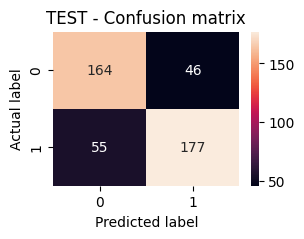

In [ ]:
cm = confusion_matrix(data_sets['test'][1], accuracy_rf['test'][1])
 
plt.figure(figsize=(3,2))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('TEST - Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

____
>El modelo de regresión logística muestra un mejor performance respecto al bosque aleatorio. El bosque aleatorio muestra sobre entrenamiento mientras que el de regresión muestra una buena generalización respecto a los datos de prueba y validación.
____